In [3]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

import nltk
import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import matplotlib.pyplot as plt

In [4]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nowak\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nowak\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nowak\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\nowak\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


In [5]:
df = pd.read_csv("../data/IMDB Dataset.csv")

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text) # remove html tags like <br /> etc
    text = re.sub(r"http\S+|www\S+", "", text) # remove URLs
    text = re.sub(r"[^a-z\s]", "", text) # remove punctuation (!?- etc) and numbers
    text = re.sub(r"\s+", " ", text).strip() # remove unnecesary whitespaces (fe "  ")
    return text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatize_text_nltk(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(token, get_wordnet_pos(tag))
        for token, tag in tagged_tokens
    ]
    return " ".join(lemmatized)

def evaluate_model(model, X_test, y_test, label_names=None, title="Confusion Matrix"):
    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

In [7]:
df["review"] = df["review"].apply(clean_text)

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment"])  # positive=1, negative=0
df_lemmatized=df.copy(deep=True)
df_lemmatized["review"] = df_lemmatized["review"].progress_apply(lemmatize_text_nltk)

X_train, X_test, y_train, y_test = train_test_split(
    df["review"], df["label"], test_size=0.2, stratify=df["label"]
)

X_lemmatize_train, X_lemmatize_test, y_lemmatize_train, y_lemmatize_test = train_test_split(
    df_lemmatized["review"], df_lemmatized["label"], test_size=0.2, stratify=df_lemmatized["label"]
)

df_lemmatized

100%|██████████| 50000/50000 [06:07<00:00, 136.12it/s]


,review,sentiment,label
0,one of the other reviewer have mention that af...,positive,1
1,a wonderful little production the filming tech...,positive,1
2,i think this be a wonderful way to spend time ...,positive,1
3,basically theres a family where a little boy j...,negative,0
4,petter matteis love in the time of money be a ...,positive,1
...,...,...,...
49995,i think this movie do a down right good job it...,positive,1
49996,bad plot bad dialogue bad act idiotic direct t...,negative,0
49997,i be a catholic taught in parochial elementary...,negative,0
49998,im go to have to disagree with the previous co...,negative,0


In [8]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LinearSVC())
])


param_grid = {
    "tfidf__max_features": [10000, 20000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 5],
    "tfidf__max_df": [0.95, 0.9],
    "clf__C": [0.1, 1, 10],
}
# Najlepsze parametry: {'clf__C': 0.1, 'tfidf__max_df': 0.95, 'tfidf__max_features': 20000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
# Najlepszy wynik CV bez lematyzacji: 0.8885500411096597

# Najlepsze parametry: {'clf__C': 0.1, 'tfidf__max_df': 0.95, 'tfidf__max_features': 20000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
# Najlepszy wynik CV z lematyzacją: 0.8869499354853003

param_grid = {
    "tfidf__max_features": [5000, 10000, 20000],
    "tfidf__ngram_range": [(1, 2), (1,3)],
    "tfidf__min_df": [1,2],
    "tfidf__max_df": [0.95,0.9],
    "tfidf__sublinear_tf": [True, False],
    "clf__C": [0.1, 1],
}
# Najlepsze parametry: {'clf__C': 0.1, 'tfidf__max_df': 0.95, 'tfidf__max_features': 20000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__sublinear_tf': True}
# Najlepszy wynik bez lematyzacji CV: 0.8905000148627534

# Najlepsze parametry: {'clf__C': 0.1, 'tfidf__max_df': 0.95, 'tfidf__max_features': 20000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__sublinear_tf': True}
# Najlepszy wynik CV z lematyzacją: 0.8885248998631595

In [9]:
# grid = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=3,
#     n_jobs=-1,
#     verbose=2,
#     scoring='accuracy'
# )
#
# grid.fit(X_lemmatize_train, y_lemmatize_train)
#
# print("Najlepsze parametry:", grid.best_params_)
# print("Najlepszy wynik CV:", grid.best_score_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


KeyboardInterrupt: 


Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



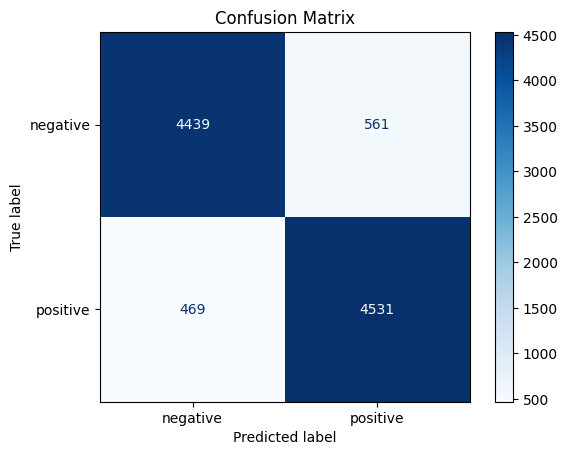

In [10]:
# Pipeline z najlepszymi parametrami
final_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        max_features=20000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )),
    ("clf", LinearSVC(C=0.1))
])

final_pipeline.fit(X_train, y_train)

evaluate_model(final_pipeline, X_test, y_test, label_names=label_encoder.classes_)
